# Arctic ERA5 Analysis 


In [1]:


import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
file_name = 'ERA5_energy_200001-202504.nc'
root = nc.Dataset(file_name, 'r')

lon = np.array(root['longitude'][:])
lat = np.array(root['latitude'][:]) #90-60
lat_w = np.cos(np.deg2rad(lat))
time = np.array(root['valid_time'][:])
energy_flux = np.array(root['vited'][:,:,:])  


## Functions for computation and plotting

In [3]:
def compute_lat_weighted_mean(data, lat):
    lat_weights = np.cos(np.deg2rad(lat))
    global_mean = np.zeros(data.shape[0])
    for t in range(data.shape[0]):
        monthly_data = data[t, :, :]
        zonal_mean = np.mean(monthly_data, axis=1)
        global_mean[t] = np.average(zonal_mean, weights=lat_weights)
    return global_mean

def compute_annual_mean(monthly_series, start_year=2000):
    n_months = len(monthly_series)
    n_years = n_months // 12
    annual_series = np.zeros(n_years)
    for y in range(n_years):
        annual_series[y] = np.mean(monthly_series[y * 12:(y + 1) * 12])
    years = np.arange(start_year, start_year + n_years)
    return years, annual_series


In [4]:
def plot_energy_flux_timeseries(x, energy_data, is_annual=False, time_label='Time', save_path=None, is_dEdt=True):
    lw_width = 2 if is_annual else 1

    # Calculate trend line
    energy_trend = np.poly1d(np.polyfit(x, energy_data, 1))

    # Create figure
    plt.figure(figsize=(12, 6))
    plt.plot(x, energy_data, color='red', marker='s', linewidth=lw_width, label='ERA5 dE/dt' if is_dEdt else 'ERA5 Energy Flux')
    plt.plot(x, energy_trend(x), 'k--', linewidth=1.5, label='Trend')

    plt.xlabel(time_label)
    plt.ylabel('Atmospheric Energy Uptake (dE/dt, W/m²)' if is_dEdt else 'Energy Flux (W/m²)')

    # Set title
    if is_annual:
        if is_dEdt:
            plt.title('ERA5: Annual Mean Arctic Atmospheric Energy Uptake (dE/dt)', fontsize=16)
        else:
            plt.title('ERA5: Annual Mean Arctic Atmospheric Energy Flux', fontsize=16)
    else:
        if is_dEdt:
            plt.title('ERA5: Monthly Arctic Atmospheric Energy Uptake (dE/dt)', fontsize=16)
        else:
            plt.title('ERA5: Monthly Arctic Atmospheric Energy Flux', fontsize=16)

    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


In [5]:
def compute_arctic_seasonal_means_w(data, lat, time, start_year=2000, start_month=1):
  
    # Compute monthly latitude-weighted means
    weighted_monthly = compute_lat_weighted_mean(data, lat)

    # Number of months and complete years in the data
    n_months = len(time)
    n_years = n_months // 12
    
    if start_month == 1:  # Starting in January
        summer_indices = [3, 4, 5, 6, 7, 8]     # Apr–Sep (0-indexed: 3-8)
        winter_indices = [9, 10, 11, 0, 1, 2]   # Oct–Mar (0-indexed: 9-11, 0-2)

    # Calculate how many complete summers and winters we can get
    # Summer: need months 3-8 of each year
    max_summer_year = start_year + (n_months - 1) // 12
    if (n_months % 12) <= 8:  # If we don't have Sep of the last year
        max_summer_year -= 1
    
    # Winter: need Oct-Dec of year Y + Jan-Mar of year Y+1
    # So we need at least 15 months to get the first winter (Oct Y0 to Mar Y1)
    max_winter_year = start_year
    for y in range(n_years + 1):
        # Check if we have all 6 months for winter starting in year (start_year + y)
        winter_months_available = True
        for m in winter_indices:
            if m >= 9:  # Oct, Nov, Dec of year y
                idx = y * 12 + m
            else:  # Jan, Feb, Mar of year y+1
                idx = (y + 1) * 12 + m
            if idx >= n_months:
                winter_months_available = False
                break
        
        if winter_months_available:
            max_winter_year = start_year + y
        else:
            break

    
    # Calculate arrays
    n_summers = max_summer_year - start_year + 1
    n_winters = max_winter_year - start_year + 1
    
    summer_means = np.zeros(n_summers)
    winter_means = np.zeros(n_winters)

    # Calculate summer means
    for i, year in enumerate(range(start_year, max_summer_year + 1)):
        y = year - start_year  # year index
        summer_monthly = []
        for m in summer_indices:
            idx = y * 12 + m
            if idx < n_months:
                summer_monthly.append(weighted_monthly[idx])
        
        summer_means[i] = np.mean(summer_monthly) if len(summer_monthly) == 6 else np.nan

    # Calculate winter means
    for i, year in enumerate(range(start_year, max_winter_year + 1)):
        y = year - start_year  # year index
        winter_monthly = []
        for m in winter_indices:
            if m >= 9:  # Oct, Nov, Dec of current year
                idx = y * 12 + m
            else:  # Jan, Feb, Mar of next year
                idx = (y + 1) * 12 + m
            if idx < n_months:
                winter_monthly.append(weighted_monthly[idx])

        winter_means[i] = np.mean(winter_monthly) if len(winter_monthly) == 6 else np.nan

    # Return years arrays
    summer_years = np.arange(start_year, max_summer_year + 1)
    winter_years = np.arange(start_year, max_winter_year + 1)
    
    return summer_years, winter_years, summer_means, winter_means


In [6]:
def plot_summer_energy_flux(summer_years, summer_data, save_path=None, is_dEdt=True):
    summer_trend = np.poly1d(np.polyfit(summer_years, summer_data, 1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(summer_years, summer_data, 'orange', marker='s', linewidth=2, label='Summer dE/dt' if is_dEdt else 'Summer Energy Flux')
    plt.plot(summer_years, summer_trend(summer_years), 'k--', linewidth=1.5, label='Trend')

    plt.xlabel('Year')
    plt.ylabel('Atmospheric Energy Uptake (dE/dt, W/m²)' if is_dEdt else 'Energy Flux (W/m²)')
    plt.title(
        'ERA5: Summer Arctic Atmospheric Energy Uptake (dE/dt, April–September)' if is_dEdt 
        else 'ERA5: Summer Arctic Atmospheric Energy Flux (April–September)', 
        fontsize=16
    )
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


def plot_winter_energy_flux(winter_years, winter_data, save_path=None, is_dEdt=True):
    winter_trend = np.poly1d(np.polyfit(winter_years, winter_data, 1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(winter_years, winter_data, 'blue', marker='s', linewidth=2, label='Winter dE/dt' if is_dEdt else 'Winter Energy Flux')
    plt.plot(winter_years, winter_trend(winter_years), 'k--', linewidth=1.5, label='Trend')

    plt.xlabel('Year')
    plt.ylabel('Atmospheric Energy Uptake (dE/dt, W/m²)' if is_dEdt else 'Energy Flux (W/m²)')
    plt.title(
        'ERA5: Winter Arctic Atmospheric Energy Uptake (dE/dt, October–March)' if is_dEdt 
        else 'ERA5: Winter Arctic Atmospheric Energy Flux (October–March)',
        fontsize=16
    )
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()


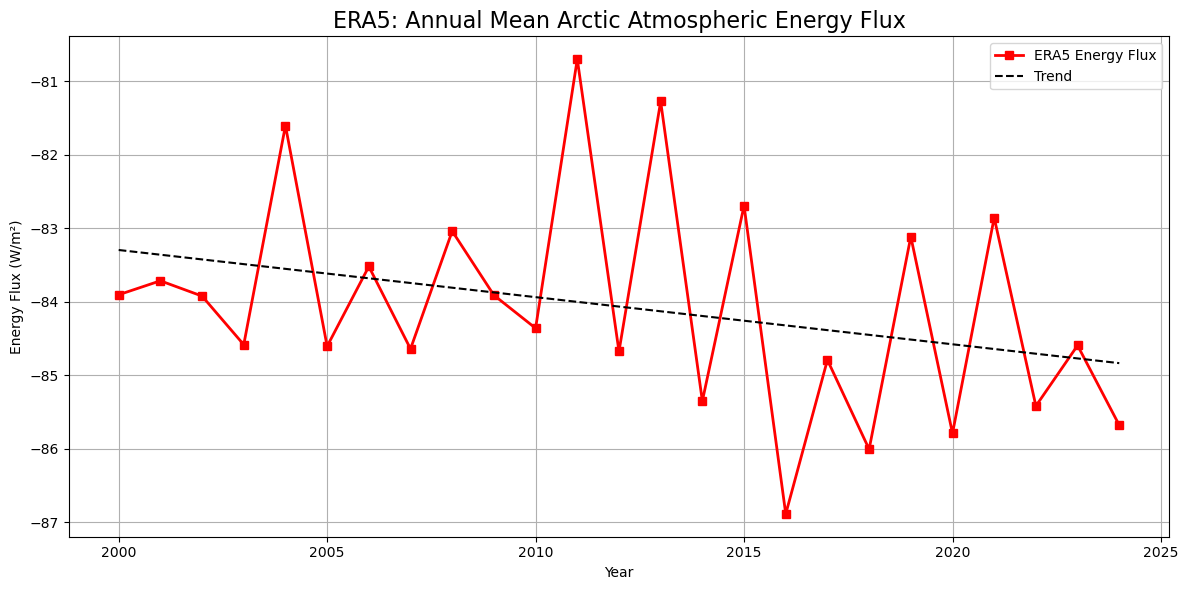

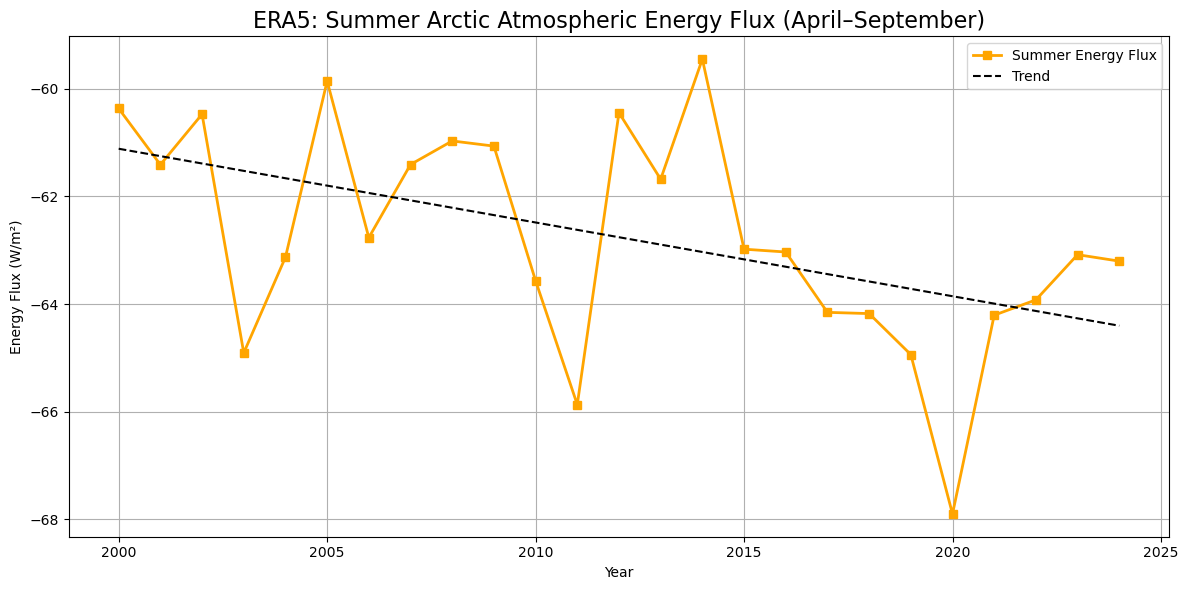

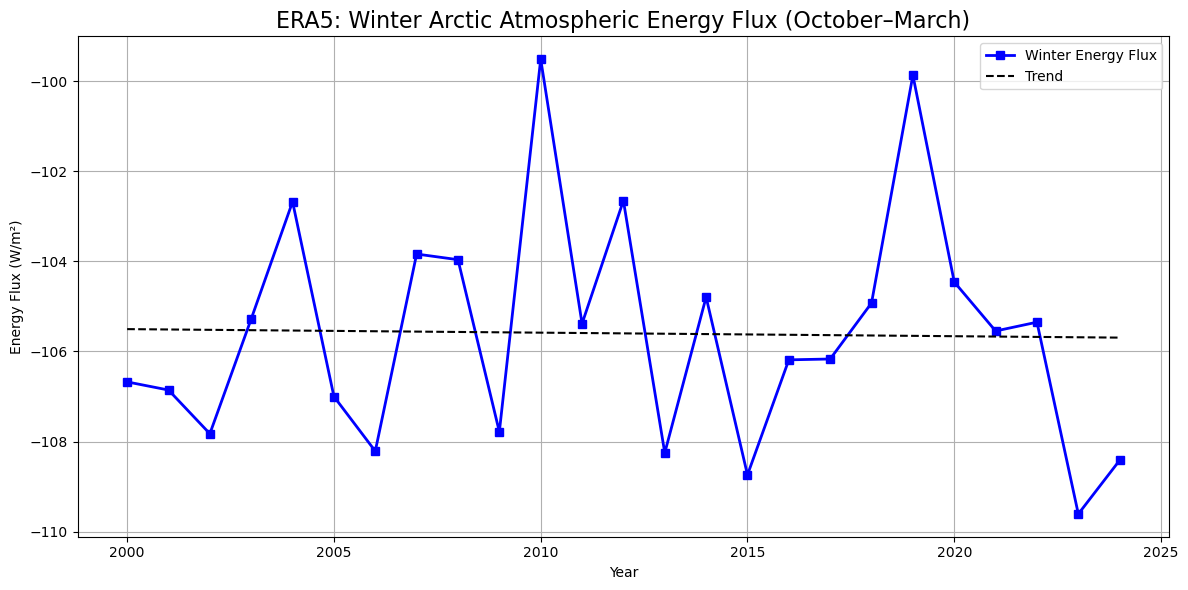

In [7]:

# Calculate global means using latitude weighting
energy_flux_mon_mean = compute_lat_weighted_mean(energy_flux, lat)

# Calculate annual means
years, energy_flux_annual = compute_annual_mean(energy_flux_mon_mean, start_year=2000)

# Calculate seasonal means
summer_years, winter_years, energy_flux_summer, energy_flux_winter = compute_arctic_seasonal_means_w(
    energy_flux, lat, time, 2000, 1)

# Setup time arrays
months = np.arange(len(time))
years_from_time = 2000 + months / 12


# Plot annual energy flux
plot_energy_flux_timeseries(
    x=years,
    energy_data=energy_flux_annual,
    is_annual=True,
    time_label='Year',
    save_path='era5_annual_energy_flux.png',
    is_dEdt=False
)

# Plot summer energy flux
plot_summer_energy_flux(
    summer_years,
    energy_flux_summer,
    save_path='era5_summer_energy_flux.png',
    is_dEdt=False
)

# Plot winter energy flux
plot_winter_energy_flux(
    winter_years,
    energy_flux_winter,
    save_path='era5_winter_energy_flux.png',
    is_dEdt=False
)

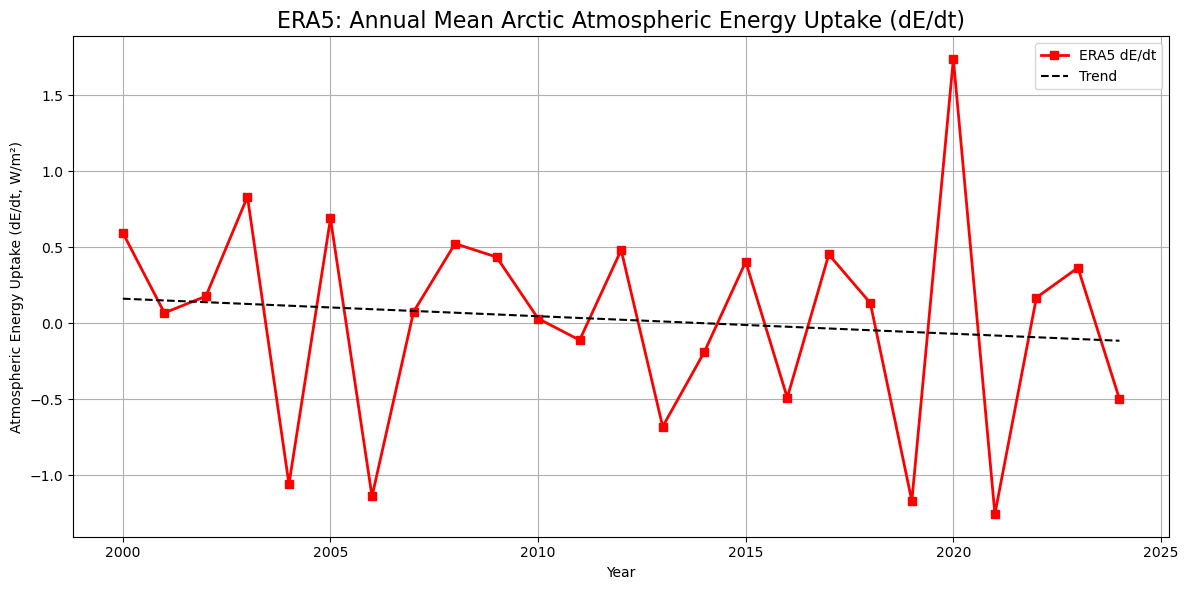

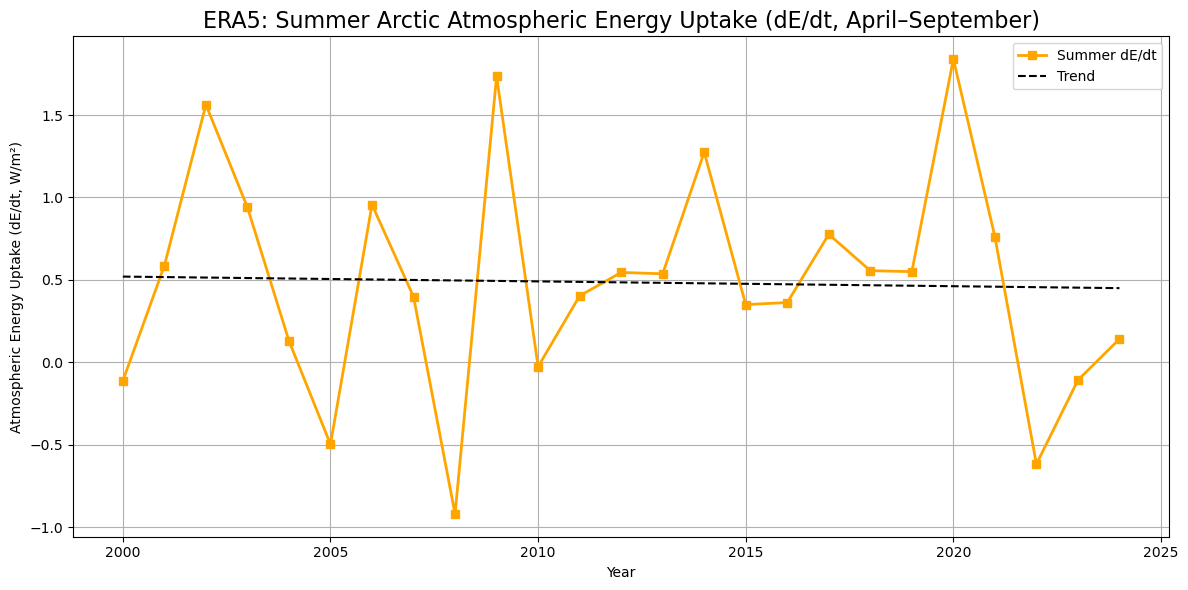

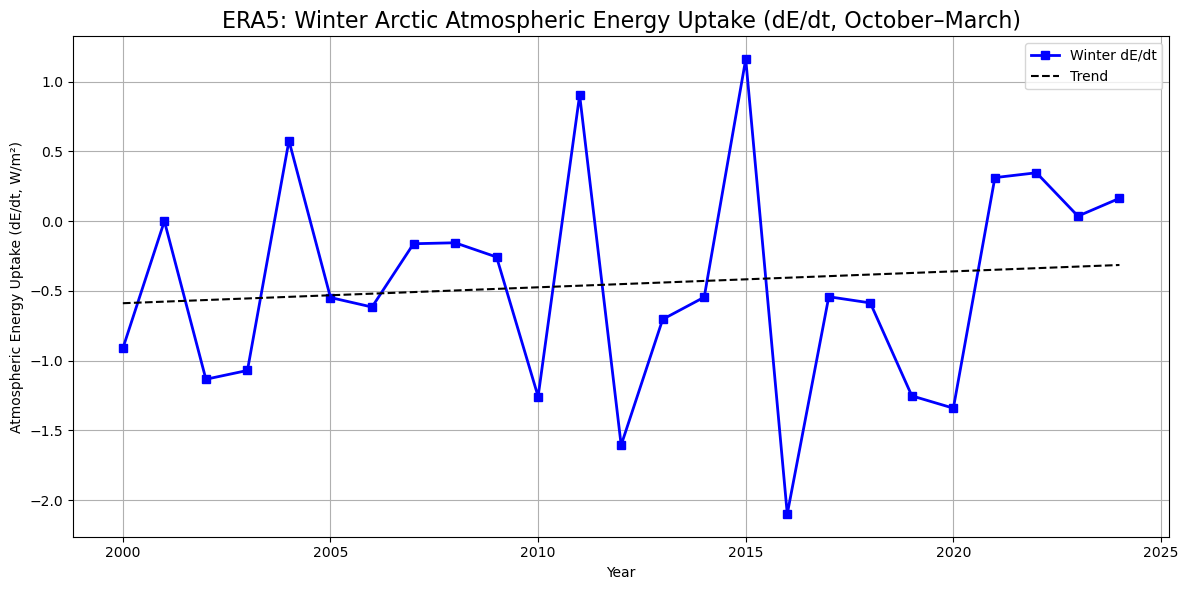

In [8]:
# Load vitoe: vertically integrated total atmospheric energy (in J/m²)
vitoe = np.array(root['vitoe'][:])  # Expected shape: (time, lat, lon)

# Compute time derivative to get dE/dt in W/m²
dt = 2.63e6  # seconds in a month (approx.)
dE_dt = (vitoe[1:] - vitoe[:-1]) / dt  # shape: (t-1, lat, lon)

# Compute latitude-weighted monthly mean of dE/dt
dE_dt_mon_mean = compute_lat_weighted_mean(dE_dt, lat)

# Compute annual means
years, dE_dt_annual = compute_annual_mean(dE_dt_mon_mean, start_year=2000)

# Compute seasonal means (summer and winter)
summer_years, winter_years, dE_dt_summer, dE_dt_winter = compute_arctic_seasonal_means_w(
    dE_dt, lat, time[1:], 2000, 1  # use time[1:] because dE_dt is one time step shorter
)

# Set up time array for monthly series
months = np.arange(len(time[1:]))
years_from_time = 2000 + months / 12

# ---------------------- PLOTS ----------------------

# Plot annual atmospheric energy uptake
plot_energy_flux_timeseries(
    x=years,
    energy_data=dE_dt_annual,
    is_annual=True,
    time_label='Year',
    save_path='era5_annual_dEdt_flux.png',
    is_dEdt=True
)

# Plot summer atmospheric energy uptake
plot_summer_energy_flux(
    summer_years,
    dE_dt_summer,
    save_path='era5_summer_dEdt_flux.png',
    is_dEdt=True
)

# Plot winter atmospheric energy uptake
plot_winter_energy_flux(
    winter_years,
    dE_dt_winter,
    save_path='era5_winter_dEdt_flux.png',
    is_dEdt=True
)